<a href="https://colab.research.google.com/github/nanda55/Remote-Sensing-Image-Classification/blob/main/Kuchipudi_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from sklearn.metrics import mean_squared_error
import time
from functools import partialmethod
from numpy.core.fromnumeric import mean
import math
from sklearn.utils import shuffle
from numpy.linalg import eig
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import PIL.Image
import cv2
import matplotlib.pyplot as plt
import pathlib
import tensorflow_datasets as tfds

allow_growth = True


In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_dir_path = "/content/drive/MyDrive/Datasets_images"     # Directory for datasets

os.chdir(input_dir_path)

class_list = ["airplane","cloud","dense_residential","desert","forest","island","rectangular_farmland","snowberg"]

In [ ]:
data_dir = pathlib.Path("/content/drive/MyDrive/Datasets_images")
image_count = list(data_dir.glob('*/*.jpg'))
len(image_count)

5600

In [ ]:
batch_size = 67
img_height = 120
img_width = 120

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  class_names = class_list,
  seed=123,
  color_mode = "rgb",
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  class_names = class_list,
  seed=123,
  color_mode = "rgb",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5600 files belonging to 8 classes.
Using 4480 files for training.
Found 5600 files belonging to 8 classes.
Using 1120 files for validation.


In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_ds.class_names

['airplane',
 'cloud',
 'dense_residential',
 'desert',
 'forest',
 'island',
 'rectangular_farmland',
 'snowberg']

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

 **`MODEL 1\`**: Created a **typical CNN architecture** with the image dimensions as (120,120,3). Conv1(3/3)->Maxp1->Conv2(3/3)->Maxp2->flatten->MLPdense(2000 neu)->Output(Softmax)

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
input = tf.keras.Input(shape=(120,120,3))
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(input)
maxp_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_1)
conv_2 = tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_1)
maxp_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_2)
flatten = tf.keras.layers.Flatten()(maxp_2)
hidden = tf.keras.layers.Dense(2000, activation='relu')(flatten)
output = tf.keras.layers.Dense(8, activation="softmax")(hidden)

model_typical_cnn = tf.keras.Model(input, output)
Hidden=tf.keras.Model(input,flatten)

In [ ]:
model_typical_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 48)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 43200)             0     

In [ ]:
tf.keras.utils.set_random_seed(111)
model_typical_cnn.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
start_time1 = time.time()
history_typical_cnn = model_typical_cnn.fit(train_ds, epochs=50, validation_data=val_ds)
end_time1 = time.time() - start_time1

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 15s 221ms/step - loss: 1.9180 - accuracy: 0.5685 - val_loss: 0.8122 - val_accuracy: 0.7018
Epoch 2/50
67/67 [==============================] - 15s 218ms/step - loss: 0.5585 - accuracy: 0.7942 - val_loss: 0.7325 - val_accuracy: 0.7616
Epoch 3/50
67/67 [==============================] - 15s 220ms/step - loss: 0.4659 - accuracy: 0.8371 - val_loss: 0.6101 - val_accuracy: 0.7866
Epoch 4/50
67/67 [==============================] - 15s 222ms/step - loss: 0.3864 - accuracy: 0.8701 - val_loss: 0.6337 - val_accuracy: 0.8080
Epoch 5/50
67/67 [==============================] - 15s 219ms/step - loss: 0.3293 - accuracy: 0.8895 - val_loss: 0.7247 - val_accuracy: 0.7643
Epoch 6/50
67/67 [==============================] - 15s 218ms/step - loss: 0.2952 - accuracy: 0.8993 - val_loss: 0.5961 - val_accuracy: 0.7937
Epoch 7/50
67/67 [==============================] - 15s 218ms/step - loss: 0.2443 - accuracy: 0.9187 - val_loss: 0.5328 - val_accuracy: 0.8384
Epoch 8/50

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
input_bestm = tf.keras.Input(shape=(120,120,3))
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(input_bestm)
maxp_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_1)
conv_2 = tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_1)
maxp_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_2)
flatten = tf.keras.layers.Flatten()(maxp_2)
hidden = tf.keras.layers.Dense(2000, activation='relu')(flatten)
output = tf.keras.layers.Dense(8, activation="softmax")(hidden)
model_typical_cnn_bestm = tf.keras.Model(input_bestm, output)
model_typical_cnn_bestm.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
history_typical_cnn_bestm = model_typical_cnn_bestm.fit(train_ds, epochs=20, validation_data=val_ds)



Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 16s 239ms/step - loss: 1.9180 - accuracy: 0.5685 - val_loss: 0.8122 - val_accuracy: 0.7018
Epoch 2/20
67/67 [==============================] - 16s 240ms/step - loss: 0.5585 - accuracy: 0.7942 - val_loss: 0.7325 - val_accuracy: 0.7616
Epoch 3/20
67/67 [==============================] - 16s 232ms/step - loss: 0.4659 - accuracy: 0.8371 - val_loss: 0.6101 - val_accuracy: 0.7866
Epoch 4/20
67/67 [==============================] - 16s 237ms/step - loss: 0.3864 - accuracy: 0.8701 - val_loss: 0.6337 - val_accuracy: 0.8080
Epoch 5/20
67/67 [==============================] - 16s 237ms/step - loss: 0.3293 - accuracy: 0.8895 - val_loss: 0.7247 - val_accuracy: 0.7643
Epoch 6/20
67/67 [==============================] - 16s 241ms/step - loss: 0.2952 - accuracy: 0.8993 - val_loss: 0.5961 - val_accuracy: 0.7937
Epoch 7/20
67/67 [==============================] - 16s 239ms/step - loss: 0.2443 - accuracy: 0.9187 - val_loss: 0.5328 - val_accuracy: 0.8384
Epoch 8/20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


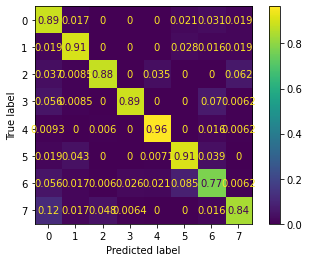

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
y_pred_test = model_typical_cnn_bestm.predict(val_ds)

predicted_categories = tf.argmax(y_pred_test, axis=1)

true_categories = tf.concat([y for x, y in val_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


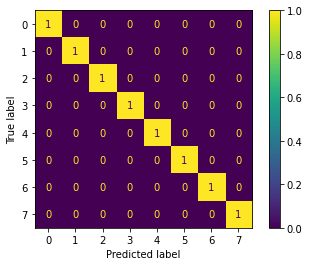

In [ ]:
y_pred_train = model_typical_cnn_bestm.predict(train_ds)

predicted_categories = tf.argmax(y_pred_train, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
end_time1

737.9220321178436

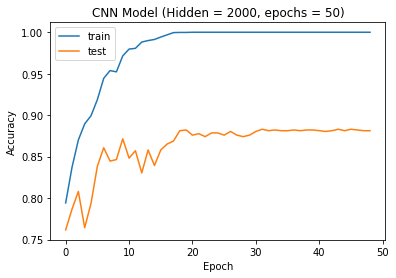

In [ ]:
plt.plot(history_typical_cnn.history['accuracy'][1:50])
plt.plot(history_typical_cnn.history['val_accuracy'][1:50])
plt.title('CNN Model (Hidden = 2000, epochs = 50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

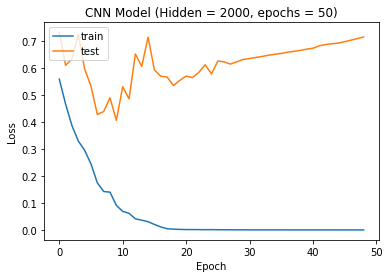

In [ ]:
plt.plot(history_typical_cnn.history['loss'][1:50])
plt.plot(history_typical_cnn.history['val_loss'][1:50])
plt.title('CNN Model (Hidden = 2000, epochs = 50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
hidden_ds=Hidden.predict(train_ds)
hidden_ds.shape

(4480, 43200)

In [ ]:
hidden_df = pd.DataFrame(hidden_ds)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, svd_solver='full')
X=pca.fit_transform(hidden_df,)
X.shape

(4480, 1490)

### **Model 2**: In the below, the same typical cnn architecture was trained after performing the pca analysis  on the flattening layer to find the number of dimensions of last hidden layer (99% of explained variance).

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
input = tf.keras.Input(shape=(120,120,3))
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(input)
maxp_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_1)
conv_2 = tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_1)
maxp_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_2)
flatten = tf.keras.layers.Flatten()(maxp_2)
hidden = tf.keras.layers.Dense(1490, activation='relu')(flatten)
output = tf.keras.layers.Dense(8, activation="softmax")(hidden)

model_typical_cnn_pca = tf.keras.Model(input, output)
model_typical_cnn_pca.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 48)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 43200)             0     

In [ ]:
model_typical_cnn_pca.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
start_time2 = time.time()
history_typical_cnn_pca = model_typical_cnn_pca.fit(train_ds, epochs=50, validation_data=val_ds)
end_time2 = time.time() - start_time2

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 15s 212ms/step - loss: 1.9289 - accuracy: 0.5395 - val_loss: 0.6922 - val_accuracy: 0.7705
Epoch 2/50
67/67 [==============================] - 14s 208ms/step - loss: 0.5908 - accuracy: 0.7933 - val_loss: 0.5397 - val_accuracy: 0.8045
Epoch 3/50
67/67 [==============================] - 14s 206ms/step - loss: 0.4639 - accuracy: 0.8413 - val_loss: 0.6082 - val_accuracy: 0.8000
Epoch 4/50
67/67 [==============================] - 14s 209ms/step - loss: 0.3716 - accuracy: 0.8681 - val_loss: 0.6097 - val_accuracy: 0.7964
Epoch 5/50
67/67 [==============================] - 14s 209ms/step - loss: 0.3243 - accuracy: 0.8935 - val_loss: 0.5487 - val_accuracy: 0.7991
Epoch 6/50
67/67 [==============================] - 14s 207ms/step - loss: 0.2811 - accuracy: 0.9029 - val_loss: 0.5524 - val_accuracy: 0.8107
Epoch 7/50
67/67 [==============================] - 14s 206ms/step - loss: 0.2867 - accuracy: 0.9009 - val_loss: 0.5315 - val_accuracy: 0.8286
Epoch 8/50

In [ ]:
end_time2

703.5472075939178

M* for second model is 23

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
input_best_pca = tf.keras.Input(shape=(120,120,3))
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(input_best_pca)
maxp_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_1)
conv_2 = tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_1)
maxp_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_2)
flatten = tf.keras.layers.Flatten()(maxp_2)
hidden = tf.keras.layers.Dense(1490, activation='relu')(flatten)
output = tf.keras.layers.Dense(8, activation="softmax")(hidden)

model_typical_cnn_pca_bestm = tf.keras.Model(input_best_pca, output)

model_typical_cnn_pca_bestm.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

history_typical_cnn_pca_bestm = model_typical_cnn_pca_bestm.fit(train_ds, epochs=23, validation_data=val_ds)


Epoch 1/23


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 15s 212ms/step - loss: 1.9289 - accuracy: 0.5395 - val_loss: 0.6922 - val_accuracy: 0.7705
Epoch 2/23
67/67 [==============================] - 14s 209ms/step - loss: 0.5908 - accuracy: 0.7933 - val_loss: 0.5397 - val_accuracy: 0.8045
Epoch 3/23
67/67 [==============================] - 14s 209ms/step - loss: 0.4639 - accuracy: 0.8413 - val_loss: 0.6082 - val_accuracy: 0.8000
Epoch 4/23
67/67 [==============================] - 14s 209ms/step - loss: 0.3716 - accuracy: 0.8681 - val_loss: 0.6097 - val_accuracy: 0.7964
Epoch 5/23
67/67 [==============================] - 14s 207ms/step - loss: 0.3243 - accuracy: 0.8935 - val_loss: 0.5487 - val_accuracy: 0.7991
Epoch 6/23
67/67 [==============================] - 14s 210ms/step - loss: 0.2811 - accuracy: 0.9029 - val_loss: 0.5524 - val_accuracy: 0.8107
Epoch 7/23
67/67 [==============================] - 14s 209ms/step - loss: 0.2867 - accuracy: 0.9009 - val_loss: 0.5315 - val_accuracy: 0.8286
Epoch 8/23

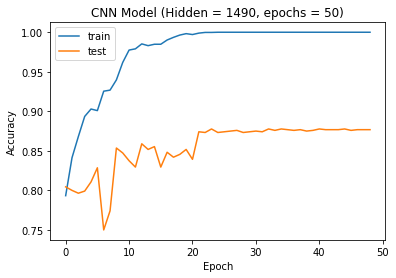

In [ ]:
plt.plot(history_typical_cnn_pca.history['accuracy'][1:50])
plt.plot(history_typical_cnn_pca.history['val_accuracy'][1:50])
plt.title('CNN Model (Hidden = 1490, epochs = 50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

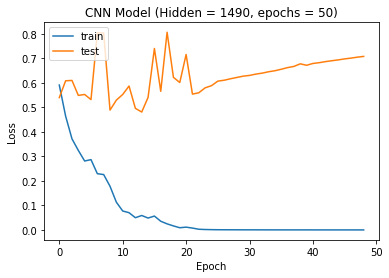

In [ ]:
plt.plot(history_typical_cnn_pca.history['loss'][1:50])
plt.plot(history_typical_cnn_pca.history['val_loss'][1:50])
plt.title('CNN Model (Hidden = 1490, epochs = 50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


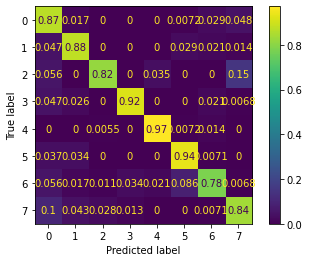

In [ ]:
y_pred_test = model_typical_cnn_pca_bestm.predict(val_ds)

predicted_categories = tf.argmax(y_pred_test, axis=1)

true_categories = tf.concat([y for x, y in val_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


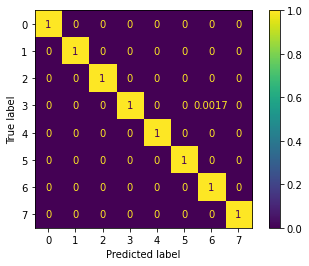

In [ ]:
y_pred_train = model_typical_cnn_pca_bestm.predict(train_ds)

predicted_categories = tf.argmax(y_pred_train, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Model 3: Created a CNN architecture by only changing the optimizer to SGD from Adam.

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_typical_cnn3 = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dense(8, activation="softmax")
])


model_typical_cnn3.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

start_time3 = time.time()
history_typical_cnn3 = model_typical_cnn3.fit(train_ds, epochs=50, validation_data=val_ds)
end_time3 = time.time() - start_time3

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 14s 205ms/step - loss: 1.7588 - accuracy: 0.3152 - val_loss: 1.3676 - val_accuracy: 0.5625
Epoch 2/50
67/67 [==============================] - 14s 203ms/step - loss: 1.2820 - accuracy: 0.5467 - val_loss: 1.0191 - val_accuracy: 0.6705
Epoch 3/50
67/67 [==============================] - 14s 204ms/step - loss: 1.0291 - accuracy: 0.6292 - val_loss: 0.9019 - val_accuracy: 0.6750
Epoch 4/50
67/67 [==============================] - 14s 204ms/step - loss: 0.9262 - accuracy: 0.6694 - val_loss: 0.8456 - val_accuracy: 0.6929
Epoch 5/50
67/67 [==============================] - 14s 202ms/step - loss: 0.8155 - accuracy: 0.7181 - val_loss: 0.7732 - val_accuracy: 0.7241
Epoch 6/50
67/67 [==============================] - 14s 205ms/step - loss: 0.7328 - accuracy: 0.7449 - val_loss: 0.8197 - val_accuracy: 0.6848
Epoch 7/50
67/67 [==============================] - 14s 206ms/step - loss: 0.6769 - accuracy: 0.7665 - val_loss: 0.7105 - val_accuracy: 0.7509
Epoch 8/50

In [ ]:
model_typical_cnn3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 48)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 43200)             0         
                                                                 
 dense (Dense)               (None, 2000)              8

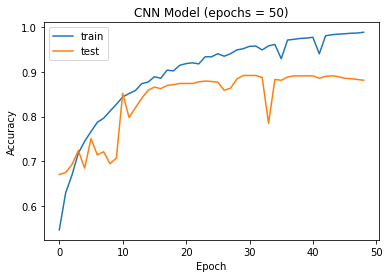

In [ ]:
plt.plot(history_typical_cnn3.history['accuracy'][1:50])
plt.plot(history_typical_cnn3.history['val_accuracy'][1:50])
plt.title('CNN Model (epochs = 50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

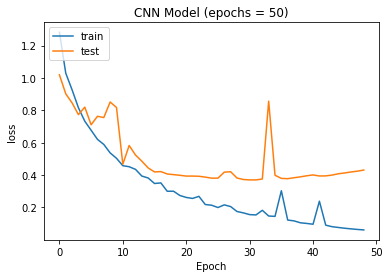

In [ ]:
plt.plot(history_typical_cnn3.history['loss'][1:50])
plt.plot(history_typical_cnn3.history['val_loss'][1:50])
plt.title('CNN Model (epochs = 50)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

For 3rd model M* is 44

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_typical_cnn3_bestm = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dense(8, activation="softmax")
])


model_typical_cnn3_bestm.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

history_typical_cnn3_bestm = model_typical_cnn3_bestm.fit(train_ds, epochs=44, validation_data=val_ds)

Epoch 1/44


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 15s 213ms/step - loss: 1.7588 - accuracy: 0.3152 - val_loss: 1.3676 - val_accuracy: 0.5625
Epoch 2/44
67/67 [==============================] - 14s 208ms/step - loss: 1.2820 - accuracy: 0.5467 - val_loss: 1.0191 - val_accuracy: 0.6705
Epoch 3/44
67/67 [==============================] - 14s 210ms/step - loss: 1.0291 - accuracy: 0.6292 - val_loss: 0.9019 - val_accuracy: 0.6750
Epoch 4/44
67/67 [==============================] - 14s 208ms/step - loss: 0.9262 - accuracy: 0.6694 - val_loss: 0.8456 - val_accuracy: 0.6929
Epoch 5/44
67/67 [==============================] - 14s 207ms/step - loss: 0.8155 - accuracy: 0.7181 - val_loss: 0.7732 - val_accuracy: 0.7241
Epoch 6/44
67/67 [==============================] - 14s 207ms/step - loss: 0.7328 - accuracy: 0.7449 - val_loss: 0.8197 - val_accuracy: 0.6848
Epoch 7/44
67/67 [==============================] - 14s 210ms/step - loss: 0.6769 - accuracy: 0.7665 - val_loss: 0.7105 - val_accuracy: 0.7509
Epoch 8/44

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


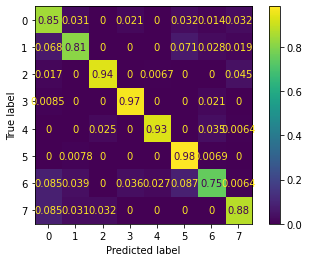

In [ ]:
y_pred_test = model_typical_cnn3_bestm.predict(val_ds)

predicted_categories = tf.argmax(y_pred_test, axis=1)

true_categories = tf.concat([y for x, y in val_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


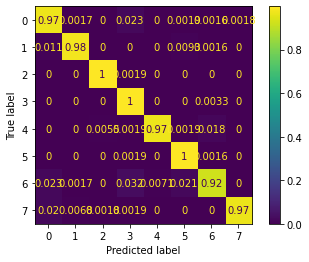

In [ ]:
y_pred_train = model_typical_cnn3_bestm.predict(train_ds)

predicted_categories = tf.argmax(y_pred_train, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.

The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_typical_cnn4 = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(8, activation="softmax")
])


model_typical_cnn4.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

start_time4 = time.time()
history_typical_cnn4 = model_typical_cnn4.fit(train_ds, epochs=50, validation_data=val_ds)
end_time4 = time.time() - start_time4

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 14s 209ms/step - loss: 1.7579 - accuracy: 0.3228 - val_loss: 1.3997 - val_accuracy: 0.5411
Epoch 2/50
67/67 [==============================] - 14s 206ms/step - loss: 1.2768 - accuracy: 0.5446 - val_loss: 1.1722 - val_accuracy: 0.5429
Epoch 3/50
67/67 [==============================] - 14s 205ms/step - loss: 1.0500 - accuracy: 0.6141 - val_loss: 0.9439 - val_accuracy: 0.6357
Epoch 4/50
67/67 [==============================] - 14s 205ms/step - loss: 0.9006 - accuracy: 0.6723 - val_loss: 0.8268 - val_accuracy: 0.7134
Epoch 5/50
67/67 [==============================] - 14s 208ms/step - loss: 0.8380 - accuracy: 0.7000 - val_loss: 0.8410 - val_accuracy: 0.6768
Epoch 6/50
67/67 [==============================] - 14s 210ms/step - loss: 0.7393 - accuracy: 0.7312 - val_loss: 0.7704 - val_accuracy: 0.7134
Epoch 7/50
67/67 [==============================] - 14s 205ms/step - loss: 0.6808 - accuracy: 0.7603 - val_loss: 0.5949 - val_accuracy: 0.8170
Epoch 8/50

In [ ]:
model_typical_cnn4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 48)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 43200)             0         
                                                                 
 dense (Dense)               (None, 2000)              8

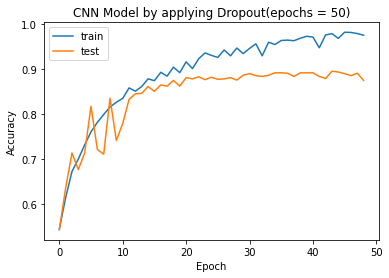

In [ ]:
plt.plot(history_typical_cnn4.history['accuracy'][1:50])
plt.plot(history_typical_cnn4.history['val_accuracy'][1:50])
plt.title('CNN Model by applying Dropout(epochs = 50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

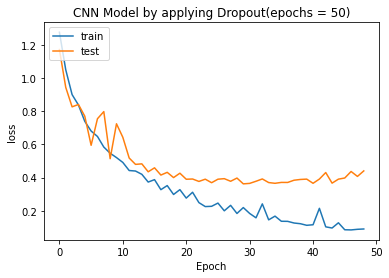

In [ ]:
plt.plot(history_typical_cnn4.history['loss'][1:50])
plt.plot(history_typical_cnn4.history['val_loss'][1:50])
plt.title('CNN Model by applying Dropout(epochs = 50)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

The best epoch M* for the fourth model is 47

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_typical_cnn4_bestm = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(8, activation="softmax")
])


model_typical_cnn4_bestm.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

history_typical_cnn4_bestm = model_typical_cnn4_bestm.fit(train_ds, epochs=47, validation_data=val_ds)

Epoch 1/47


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 15s 215ms/step - loss: 1.7579 - accuracy: 0.3228 - val_loss: 1.3997 - val_accuracy: 0.5411
Epoch 2/47
67/67 [==============================] - 14s 215ms/step - loss: 1.2768 - accuracy: 0.5446 - val_loss: 1.1722 - val_accuracy: 0.5429
Epoch 3/47
67/67 [==============================] - 14s 210ms/step - loss: 1.0500 - accuracy: 0.6141 - val_loss: 0.9439 - val_accuracy: 0.6357
Epoch 4/47
67/67 [==============================] - 14s 212ms/step - loss: 0.9006 - accuracy: 0.6723 - val_loss: 0.8268 - val_accuracy: 0.7134
Epoch 5/47
67/67 [==============================] - 14s 210ms/step - loss: 0.8380 - accuracy: 0.7000 - val_loss: 0.8410 - val_accuracy: 0.6768
Epoch 6/47
67/67 [==============================] - 14s 208ms/step - loss: 0.7393 - accuracy: 0.7312 - val_loss: 0.7704 - val_accuracy: 0.7134
Epoch 7/47
67/67 [==============================] - 14s 206ms/step - loss: 0.6808 - accuracy: 0.7603 - val_loss: 0.5949 - val_accuracy: 0.8170
Epoch 8/47

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


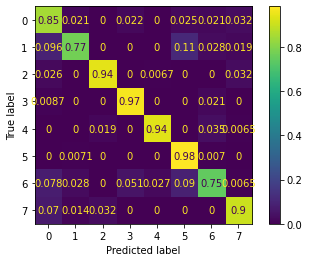

In [ ]:
y_pred_test = model_typical_cnn4_bestm.predict(val_ds)

predicted_categories = tf.argmax(y_pred_test, axis=1)

true_categories = tf.concat([y for x, y in val_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


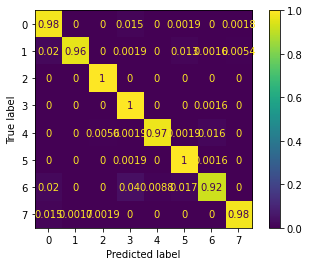

In [ ]:
y_pred_train = model_typical_cnn4_bestm.predict(train_ds)

predicted_categories = tf.argmax(y_pred_train, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Model 5: Increased channels for convolution layers 

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_typical_cnn5 = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dense(8, activation="softmax")
])


model_typical_cnn5.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

start_time5 = time.time()
history_typical_cnn5 = model_typical_cnn5.fit(train_ds, epochs=50, validation_data=val_ds)
end_time5 = time.time() - start_time5

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 14s 203ms/step - loss: 1.3636 - accuracy: 0.5248 - val_loss: 0.6911 - val_accuracy: 0.7554
Epoch 2/50
67/67 [==============================] - 14s 204ms/step - loss: 0.5468 - accuracy: 0.8125 - val_loss: 0.5392 - val_accuracy: 0.8116
Epoch 3/50
67/67 [==============================] - 13s 200ms/step - loss: 0.4189 - accuracy: 0.8565 - val_loss: 0.6325 - val_accuracy: 0.8054
Epoch 4/50
67/67 [==============================] - 13s 198ms/step - loss: 0.3480 - accuracy: 0.8875 - val_loss: 0.4633 - val_accuracy: 0.8446
Epoch 5/50
67/67 [==============================] - 13s 198ms/step - loss: 0.2956 - accuracy: 0.9022 - val_loss: 0.4948 - val_accuracy: 0.8438
Epoch 6/50
67/67 [==============================] - 13s 201ms/step - loss: 0.2345 - accuracy: 0.9232 - val_loss: 0.3679 - val_accuracy: 0.8839
Epoch 7/50
67/67 [==============================] - 13s 201ms/step - loss: 0.1937 - accuracy: 0.9362 - val_loss: 0.4119 - val_accuracy: 0.8732
Epoch 8/50

In [ ]:
model_typical_cnn5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        27712     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

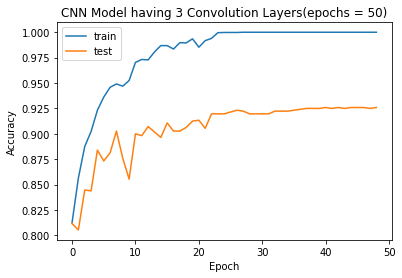

In [ ]:
plt.plot(history_typical_cnn5.history['accuracy'][1:50])
plt.plot(history_typical_cnn5.history['val_accuracy'][1:50])
plt.title('CNN Model having 3 Convolution Layers(epochs = 50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

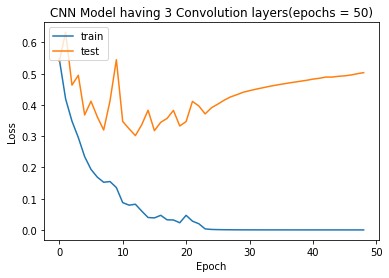

In [ ]:
plt.plot(history_typical_cnn5.history['loss'][1:50])
plt.plot(history_typical_cnn5.history['val_loss'][1:50])
plt.title('CNN Model having 3 Convolution layers(epochs = 50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_typical_cnn5_bestm = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dense(8, activation="softmax")
])


model_typical_cnn5_bestm.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

history_typical_cnn5_bestm = model_typical_cnn5_bestm.fit(train_ds, epochs=25, validation_data=val_ds)


Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 14s 206ms/step - loss: 1.3636 - accuracy: 0.5248 - val_loss: 0.6911 - val_accuracy: 0.7554
Epoch 2/25
67/67 [==============================] - 14s 205ms/step - loss: 0.5468 - accuracy: 0.8125 - val_loss: 0.5392 - val_accuracy: 0.8116
Epoch 3/25
67/67 [==============================] - 14s 203ms/step - loss: 0.4189 - accuracy: 0.8565 - val_loss: 0.6325 - val_accuracy: 0.8054
Epoch 4/25
67/67 [==============================] - 14s 204ms/step - loss: 0.3480 - accuracy: 0.8875 - val_loss: 0.4633 - val_accuracy: 0.8446
Epoch 5/25
67/67 [==============================] - 14s 204ms/step - loss: 0.2956 - accuracy: 0.9022 - val_loss: 0.4948 - val_accuracy: 0.8438
Epoch 6/25
67/67 [==============================] - 14s 208ms/step - loss: 0.2345 - accuracy: 0.9232 - val_loss: 0.3679 - val_accuracy: 0.8839
Epoch 7/25
67/67 [==============================] - 14s 207ms/step - loss: 0.1937 - accuracy: 0.9362 - val_loss: 0.4119 - val_accuracy: 0.8732
Epoch 8/25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


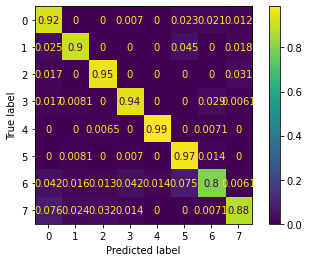

In [ ]:
y_pred_test = model_typical_cnn5_bestm.predict(val_ds)

predicted_categories = tf.argmax(y_pred_test, axis=1)

true_categories = tf.concat([y for x, y in val_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


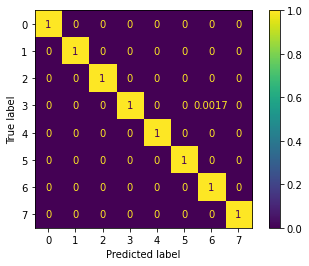

In [ ]:
y_pred_train = model_typical_cnn5_bestm.predict(train_ds)

predicted_categories = tf.argmax(y_pred_train, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Model 6: Applied pca on model 5

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
input_pca_6 = tf.keras.Input(shape=(120,120,3))
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(input_pca_6)
maxp_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_1)
conv_2 = tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_1)
maxp_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_2)
conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_2)
maxp_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_3)
flatten = tf.keras.layers.Flatten()(maxp_3)
hidden = tf.keras.layers.Dense(2000, activation='relu')(flatten)
output = tf.keras.layers.Dense(8, activation="softmax")(hidden)

model_cnn6 = tf.keras.Model(input_pca_6, output)
Hidden6=tf.keras.Model(input_pca_6,flatten)

In [ ]:
hidden_ds6=Hidden6.predict(train_ds)
hidden_ds6.shape



(4480, 14400)

In [ ]:
hidden_df6 = pd.DataFrame(hidden_ds6)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, svd_solver='full')
X6=pca.fit_transform(hidden_df6,)
X6.shape

(4480, 228)

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
input_pca_6 = tf.keras.Input(shape=(120,120,3))
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(input_pca_6)
maxp_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_1)
conv_2 = tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_1)
maxp_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_2)
conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_2)
maxp_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_3)
flatten = tf.keras.layers.Flatten()(maxp_3)
hidden = tf.keras.layers.Dense(228, activation='relu')(flatten)
output = tf.keras.layers.Dense(8, activation="softmax")(hidden)

model_cnn6 = tf.keras.Model(input_pca_6, output)
model_cnn6.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        27712 

In [ ]:
tf.keras.utils.set_random_seed(111)
model_cnn6.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
start_time6 = time.time()
history_cnn6 = model_cnn6.fit(train_ds, epochs=50, validation_data=val_ds)
end_time6 = time.time() - start_time6

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 12s 176ms/step - loss: 1.2138 - accuracy: 0.5451 - val_loss: 0.6612 - val_accuracy: 0.7652
Epoch 2/50
67/67 [==============================] - 12s 172ms/step - loss: 0.5668 - accuracy: 0.7978 - val_loss: 0.5065 - val_accuracy: 0.8205
Epoch 3/50
67/67 [==============================] - 11s 170ms/step - loss: 0.4627 - accuracy: 0.8411 - val_loss: 0.5141 - val_accuracy: 0.8295
Epoch 4/50
67/67 [==============================] - 11s 170ms/step - loss: 0.3768 - accuracy: 0.8694 - val_loss: 0.5639 - val_accuracy: 0.8116
Epoch 5/50
67/67 [==============================] - 11s 168ms/step - loss: 0.3343 - accuracy: 0.8877 - val_loss: 0.4206 - val_accuracy: 0.8643
Epoch 6/50
67/67 [==============================] - 11s 169ms/step - loss: 0.2953 - accuracy: 0.9007 - val_loss: 0.3653 - val_accuracy: 0.8804
Epoch 7/50
67/67 [==============================] - 11s 168ms/step - loss: 0.2384 - accuracy: 0.9237 - val_loss: 0.3796 - val_accuracy: 0.8893
Epoch 8/50

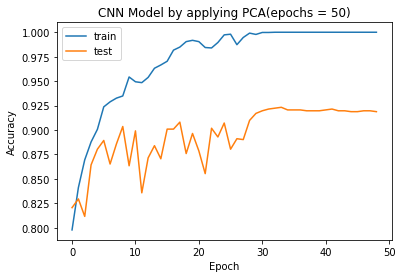

In [ ]:
plt.plot(history_cnn6.history['accuracy'][1:50])
plt.plot(history_cnn6.history['val_accuracy'][1:50])
plt.title('CNN Model by applying PCA(epochs = 50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

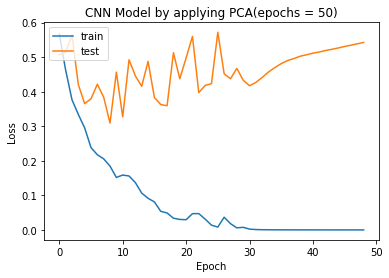

In [ ]:
plt.plot(history_cnn6.history['loss'][1:50])
plt.plot(history_cnn6.history['val_loss'][1:50])
plt.title('CNN Model by applying PCA(epochs = 50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
input_pca_best_6 = tf.keras.Input(shape=(120,120,3))
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(input_pca_best_6)
maxp_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_1)
conv_2 = tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_1)
maxp_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_2)
conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same")(maxp_2)
maxp_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same")(conv_3)
flatten = tf.keras.layers.Flatten()(maxp_3)
hidden = tf.keras.layers.Dense(228, activation='relu')(flatten)
output = tf.keras.layers.Dense(8, activation="softmax")(hidden)

model_cnn6_bestm = tf.keras.Model(input_pca_best_6, output)

model_cnn6_bestm.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

history_cnn6_bestm = model_cnn6_bestm.fit(train_ds, epochs=32, validation_data=val_ds)


Epoch 1/32


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 12s 176ms/step - loss: 1.2138 - accuracy: 0.5451 - val_loss: 0.6612 - val_accuracy: 0.7652
Epoch 2/32
67/67 [==============================] - 12s 172ms/step - loss: 0.5668 - accuracy: 0.7978 - val_loss: 0.5065 - val_accuracy: 0.8205
Epoch 3/32
67/67 [==============================] - 11s 171ms/step - loss: 0.4627 - accuracy: 0.8411 - val_loss: 0.5141 - val_accuracy: 0.8295
Epoch 4/32
67/67 [==============================] - 11s 171ms/step - loss: 0.3768 - accuracy: 0.8694 - val_loss: 0.5639 - val_accuracy: 0.8116
Epoch 5/32
67/67 [==============================] - 11s 171ms/step - loss: 0.3343 - accuracy: 0.8877 - val_loss: 0.4206 - val_accuracy: 0.8643
Epoch 6/32
67/67 [==============================] - 11s 171ms/step - loss: 0.2953 - accuracy: 0.9007 - val_loss: 0.3653 - val_accuracy: 0.8804
Epoch 7/32
67/67 [==============================] - 12s 174ms/step - loss: 0.2384 - accuracy: 0.9237 - val_loss: 0.3796 - val_accuracy: 0.8893
Epoch 8/32

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


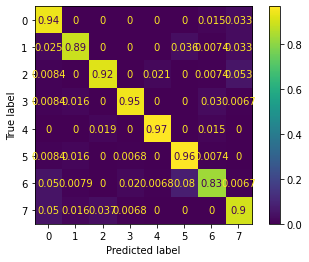

In [ ]:
y_pred_test = model_cnn6_bestm.predict(val_ds)

predicted_categories = tf.argmax(y_pred_test, axis=1)

true_categories = tf.concat([y for x, y in val_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


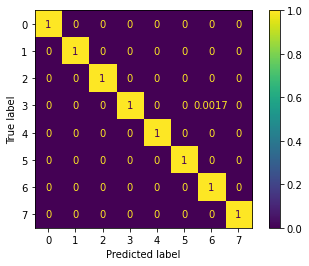

In [ ]:
y_pred_train = model_cnn6_bestm.predict(train_ds)

predicted_categories = tf.argmax(y_pred_train, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Model 7: CNN (3 channels and SGD optimizer)

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_cnn7 = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dense(8, activation="softmax")
])


In [ ]:


model_cnn7.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

start_time7 = time.time()
history_cnn7 = model_cnn7.fit(train_ds, epochs=50, validation_data=val_ds)
end_time7 = time.time() - start_time7

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 14s 204ms/step - loss: 1.9346 - accuracy: 0.2163 - val_loss: 1.7350 - val_accuracy: 0.4134
Epoch 2/50
67/67 [==============================] - 13s 200ms/step - loss: 1.5047 - accuracy: 0.4750 - val_loss: 1.1893 - val_accuracy: 0.6313
Epoch 3/50
67/67 [==============================] - 13s 200ms/step - loss: 1.1915 - accuracy: 0.5846 - val_loss: 1.1451 - val_accuracy: 0.5375
Epoch 4/50
67/67 [==============================] - 13s 200ms/step - loss: 1.0227 - accuracy: 0.6243 - val_loss: 0.8510 - val_accuracy: 0.7134
Epoch 5/50
67/67 [==============================] - 13s 202ms/step - loss: 0.9071 - accuracy: 0.6781 - val_loss: 0.7841 - val_accuracy: 0.7366
Epoch 6/50
67/67 [==============================] - 14s 202ms/step - loss: 0.8360 - accuracy: 0.7112 - val_loss: 0.8452 - val_accuracy: 0.6687
Epoch 7/50
67/67 [==============================] - 13s 199ms/step - loss: 0.7760 - accuracy: 0.7254 - val_loss: 0.7363 - val_accuracy: 0.7268
Epoch 8/50

In [ ]:
model_cnn7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        27712     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

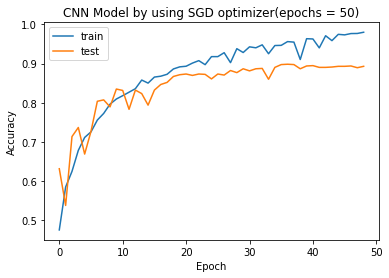

In [ ]:
plt.plot(history_cnn7.history['accuracy'][1:50])
plt.plot(history_cnn7.history['val_accuracy'][1:50])
plt.title('CNN Model by using SGD optimizer(epochs = 50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

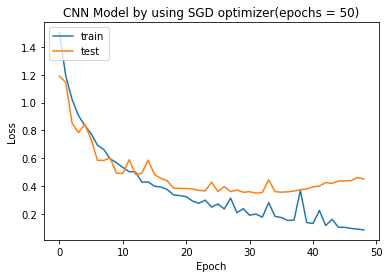

In [ ]:
plt.plot(history_cnn7.history['loss'][1:50])
plt.plot(history_cnn7.history['val_loss'][1:50])
plt.title('CNN Model by using SGD optimizer(epochs = 50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

Model 7 M* is 41

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_cnn7_bestm = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dense(8, activation="softmax")
])


model_cnn7_bestm.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

history_cnn7_bestm = model_cnn7_bestm.fit(train_ds, epochs=41, validation_data=val_ds)


Epoch 1/41


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 14s 198ms/step - loss: 1.9346 - accuracy: 0.2163 - val_loss: 1.7350 - val_accuracy: 0.4134
Epoch 2/41
67/67 [==============================] - 13s 197ms/step - loss: 1.5047 - accuracy: 0.4750 - val_loss: 1.1893 - val_accuracy: 0.6313
Epoch 3/41
67/67 [==============================] - 13s 197ms/step - loss: 1.1915 - accuracy: 0.5846 - val_loss: 1.1451 - val_accuracy: 0.5375
Epoch 4/41
67/67 [==============================] - 13s 200ms/step - loss: 1.0227 - accuracy: 0.6243 - val_loss: 0.8510 - val_accuracy: 0.7134
Epoch 5/41
67/67 [==============================] - 13s 198ms/step - loss: 0.9071 - accuracy: 0.6781 - val_loss: 0.7841 - val_accuracy: 0.7366
Epoch 6/41
67/67 [==============================] - 13s 198ms/step - loss: 0.8360 - accuracy: 0.7112 - val_loss: 0.8452 - val_accuracy: 0.6687
Epoch 7/41
67/67 [==============================] - 13s 199ms/step - loss: 0.7760 - accuracy: 0.7254 - val_loss: 0.7363 - val_accuracy: 0.7268
Epoch 8/41

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


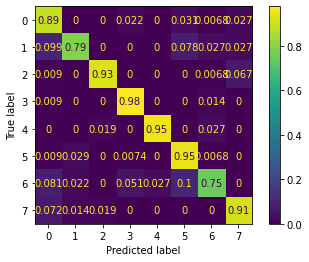

In [ ]:
y_pred_test = model_cnn7_bestm.predict(val_ds)

predicted_categories = tf.argmax(y_pred_test, axis=1)

true_categories = tf.concat([y for x, y in val_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


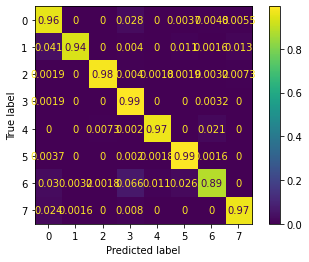

In [ ]:
y_pred_train = model_cnn7_bestm.predict(train_ds)

predicted_categories = tf.argmax(y_pred_train, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Model 8: CNN model (3 Layers) and then dropout was applied

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_cnn8 = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(8, activation="softmax")
])

In [ ]:



model_cnn8.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

start_time8 = time.time()
history_cnn8 = model_cnn8.fit(train_ds, epochs=50, validation_data=val_ds)
end_time8 = time.time() - start_time8

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 15s 213ms/step - loss: 1.3298 - accuracy: 0.5210 - val_loss: 0.6440 - val_accuracy: 0.7625
Epoch 2/50
67/67 [==============================] - 14s 209ms/step - loss: 0.5428 - accuracy: 0.8118 - val_loss: 0.5825 - val_accuracy: 0.8009
Epoch 3/50
67/67 [==============================] - 14s 213ms/step - loss: 0.4197 - accuracy: 0.8551 - val_loss: 0.5948 - val_accuracy: 0.8116
Epoch 4/50
67/67 [==============================] - 14s 215ms/step - loss: 0.3673 - accuracy: 0.8790 - val_loss: 0.6015 - val_accuracy: 0.8205
Epoch 5/50
67/67 [==============================] - 14s 207ms/step - loss: 0.2958 - accuracy: 0.9029 - val_loss: 0.3339 - val_accuracy: 0.9080
Epoch 6/50
67/67 [==============================] - 14s 207ms/step - loss: 0.2040 - accuracy: 0.9368 - val_loss: 0.3521 - val_accuracy: 0.8911
Epoch 7/50
67/67 [==============================] - 14s 215ms/step - loss: 0.1907 - accuracy: 0.9364 - val_loss: 0.3729 - val_accuracy: 0.8857
Epoch 8/50

In [ ]:
model_cnn8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        27712     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

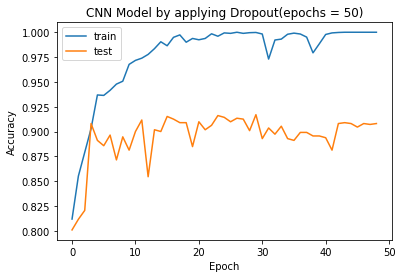

In [ ]:
plt.plot(history_cnn8.history['accuracy'][1:50])
plt.plot(history_cnn8.history['val_accuracy'][1:50])
plt.title('CNN Model by applying Dropout(epochs = 50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

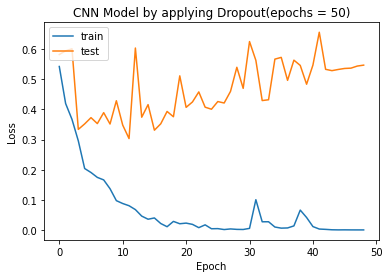

In [ ]:
plt.plot(history_cnn8.history['loss'][1:50])
plt.plot(history_cnn8.history['val_loss'][1:50])
plt.title('CNN Model by applying Dropout(epochs = 50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

Model 8: M* is 42 epochs 

In [ ]:
tf.keras.utils.set_random_seed(111)
tf.keras.backend.clear_session()
model_cnn8_bestm = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(8, activation="softmax")
])


model_cnn8_bestm.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

history_cnn8_bestm = model_cnn8_bestm.fit(train_ds, epochs=42, validation_data=val_ds)

Epoch 1/42


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 15s 218ms/step - loss: 1.3298 - accuracy: 0.5210 - val_loss: 0.6440 - val_accuracy: 0.7625
Epoch 2/42
67/67 [==============================] - 14s 215ms/step - loss: 0.5428 - accuracy: 0.8118 - val_loss: 0.5825 - val_accuracy: 0.8009
Epoch 3/42
67/67 [==============================] - 15s 218ms/step - loss: 0.4197 - accuracy: 0.8551 - val_loss: 0.5948 - val_accuracy: 0.8116
Epoch 4/42
67/67 [==============================] - 14s 213ms/step - loss: 0.3673 - accuracy: 0.8790 - val_loss: 0.6015 - val_accuracy: 0.8205
Epoch 5/42
67/67 [==============================] - 16s 237ms/step - loss: 0.2958 - accuracy: 0.9029 - val_loss: 0.3339 - val_accuracy: 0.9080
Epoch 6/42
67/67 [==============================] - 14s 215ms/step - loss: 0.2040 - accuracy: 0.9368 - val_loss: 0.3521 - val_accuracy: 0.8911
Epoch 7/42
67/67 [==============================] - 14s 216ms/step - loss: 0.1907 - accuracy: 0.9364 - val_loss: 0.3729 - val_accuracy: 0.8857
Epoch 8/42

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


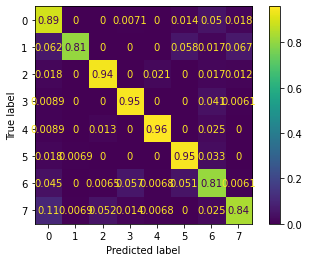

In [ ]:
y_pred_test = model_cnn8_bestm.predict(val_ds)

predicted_categories = tf.argmax(y_pred_test, axis=1)

true_categories = tf.concat([y for x, y in val_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


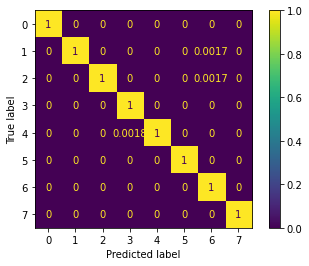

In [ ]:
y_pred_train = model_cnn8_bestm.predict(train_ds)

predicted_categories = tf.argmax(y_pred_train, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
cm = cm/cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
tf.keras.backend.clear_session()
model_typical_cnn5_second = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(120,120,3), padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(2000, activation="relu"),
                             tf.keras.layers.Dense(8, activation="softmax")
])


model_typical_cnn5_second.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

start_time9 = time.time()
history_typical_cnn5_second = model_typical_cnn5_second.fit(train_ds, epochs=50, validation_data=val_ds)
end_time9 = time.time() - start_time9

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


67/67 [==============================] - 42s 567ms/step - loss: 45.6415 - accuracy: 0.4027 - val_loss: 1.2558 - val_accuracy: 0.5259
Epoch 2/50
67/67 [==============================] - 15s 224ms/step - loss: 0.8569 - accuracy: 0.6920 - val_loss: 0.9210 - val_accuracy: 0.6812
Epoch 3/50
67/67 [==============================] - 15s 224ms/step - loss: 0.6686 - accuracy: 0.7612 - val_loss: 0.8896 - val_accuracy: 0.6741
Epoch 4/50
67/67 [==============================] - 15s 221ms/step - loss: 0.6343 - accuracy: 0.7795 - val_loss: 0.8053 - val_accuracy: 0.7545
Epoch 5/50
67/67 [==============================] - 15s 224ms/step - loss: 0.4657 - accuracy: 0.8346 - val_loss: 0.8515 - val_accuracy: 0.7196
Epoch 6/50
67/67 [==============================] - 15s 224ms/step - loss: 0.3727 - accuracy: 0.8730 - val_loss: 0.8251 - val_accuracy: 0.7375
Epoch 7/50
67/67 [==============================] - 15s 223ms/step - loss: 0.2160 - accuracy: 0.9301 - val_loss: 0.7761 - val_accuracy: 0.7554
Epoch 8/5

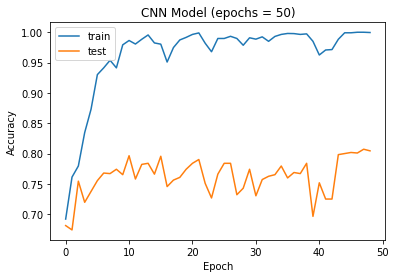

In [ ]:
plt.plot(history_typical_cnn5_second.history['accuracy'][1:50])
plt.plot(history_typical_cnn5_second.history['val_accuracy'][1:50])
plt.title('CNN Model (epochs = 50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

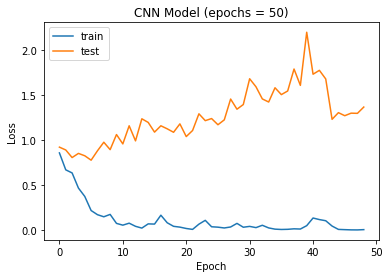

In [ ]:
plt.plot(history_typical_cnn5_second.history['loss'][1:50])
plt.plot(history_typical_cnn5_second.history['val_loss'][1:50])
plt.title('CNN Model (epochs = 50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')